In [27]:
!unzip -q ./damage.zip

In [20]:
!pip install -q ultralytics opencv-python

In [30]:
import os
import random
import shutil
import cv2
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import ultralytics
from tqdm import tqdm
from pycocotools import mask as maskUtils

In [54]:
train_root = './train'
valid_root = './valid'
test_root = './test'
cls_list = ['Scratched', 'Crushed', 'Breakage', 'Separated']

In [55]:
for folder in [train_root,valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
      s_folder = f'{folder}/{s}'
      if not os.path.exists(s_folder):
          os.makedirs(s_folder)

In [56]:
data_list = glob.glob('/content/원천데이터/TS_damage/damage/*.jpg')
len(data_list)

1200

In [57]:
data_list[0]

'/content/원천데이터/TS_damage/damage/0359094_sc-206072.jpg'

In [58]:
def draw_polygon_by_index(idx):
    image_path = data_list[idx]
    image = cv2.imread(image_path)
    json_path = image_path.replace('원천데이터', '라벨링데이터').replace('TS_damage', 'TL_damage').replace('.jpg', '.json')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(json_path, 'r') as f:
        data = json.load(f)

    for ann in data['annotations']:
        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):
                for seg in segmentation:
                    if isinstance(seg, list):
                        points = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Polygon Overlay: {os.path.basename(image_path)}')
    plt.show()

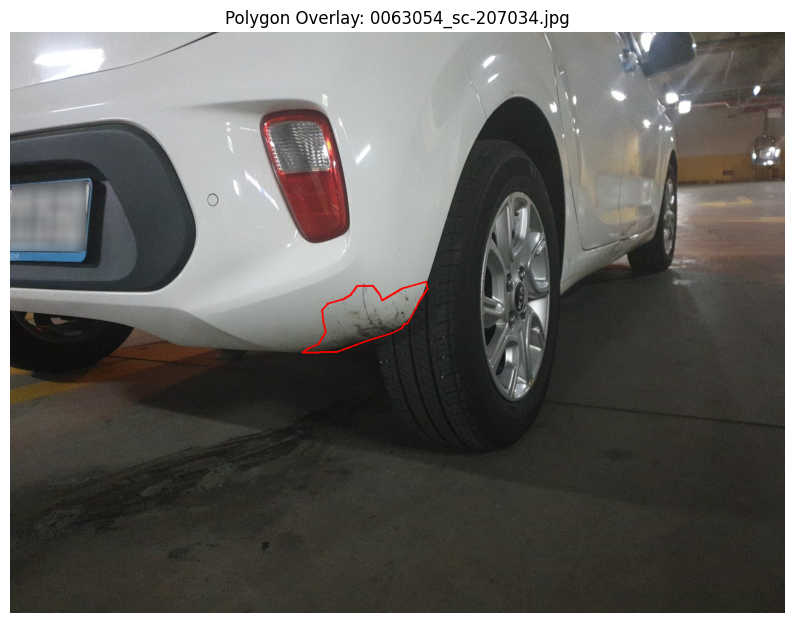

In [59]:
draw_polygon_by_index(10)

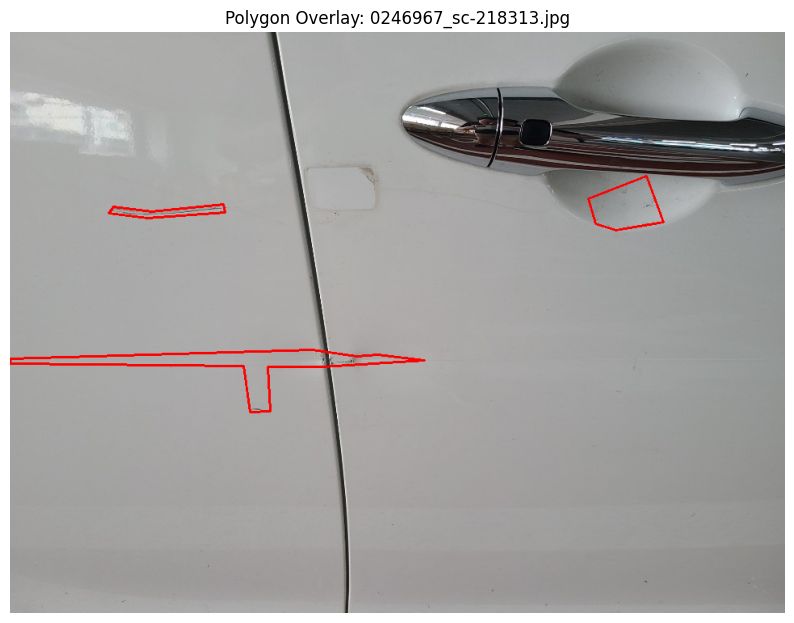

In [60]:
draw_polygon_by_index(15)

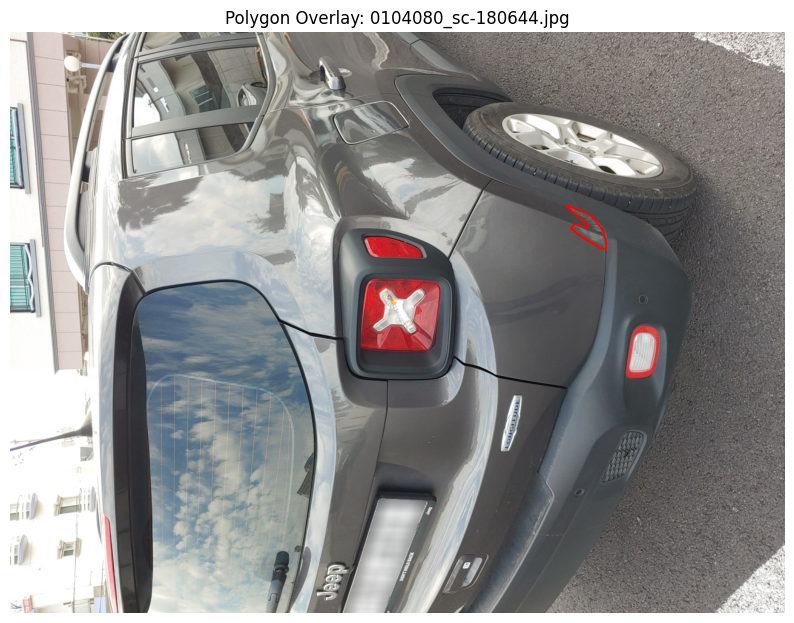

In [61]:
draw_polygon_by_index(20)

In [62]:
damage_classes = {
    "Scratched": 0,
    "Crushed": 1,
    "Breakage": 2,
    "Separated": 3
}

In [63]:
def convert_json_to_yolo(json_path, save_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)

    image_info = data['images']
    img_width, img_height = image_info['width'], image_info['height']

    yolo_annotations = []

    for ann in data['annotations']:
        if 'segmentation' in ann and 'damage' in ann:
            segmentation = ann['segmentation'][0][0]

            if isinstance(segmentation[0], list):
                segmentation = [coord for sublist in segmentation for coord in sublist]

            normalized_coords = [segmentation[i] / img_width if i % 2 == 0 else segmentation[i] / img_height for i in range(len(segmentation))]

            class_label = damage_classes.get(ann['damage'], -1)
            yolo_annotations.append(f'{class_label} ' + ' '.join(map(str, normalized_coords)))

    yolo_filename = os.path.basename(json_path).replace('.json', '.txt')
    save_path = os.path.join(save_dir, yolo_filename)

    with open(save_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))

In [64]:
for json_path in tqdm(glob.glob(os.path.join('/content/라벨링데이터/TL_damage/damage', '*.json'))):
    if not os.path.exists('./label'):
        os.makedirs('./label')
    convert_json_to_yolo(json_path, './label')
print(f'YOLO 변환 완료!!')

100%|██████████| 1200/1200 [00:00<00:00, 3811.63it/s]

YOLO 변환 완료!!


In [65]:
random.seed(2025)
file_list = glob.glob(f'./label/*.txt')

random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)
num_file

1200

In [66]:
test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

len(test_list), len(valid_list), len(train_list)

(120, 120, 960)

In [67]:
# ./label/0051632_sc-164684.txt',
test_list

['./label/0296182_sc-227015.txt',
 './label/0272786_sc-108145.txt',
 './label/0455456_sc-179835.txt',
 './label/0292789_sc-139597.txt',
 './label/0011570_as-7872658.txt',
 './label/0238908_sc-159047.txt',
 './label/0405046_as-0094498.txt',
 './label/0188888_as-0099755.txt',
 './label/0167936_sc-197322.txt',
 './label/0501846_sc-160131.txt',
 './label/0484948_sc-132079.txt',
 './label/0192738_sc-168325.txt',
 './label/0015745_sc-220289.txt',
 './label/0116621_as-0099662.txt',
 './label/0228613_as-0062902.txt',
 './label/0366849_sc-144758.txt',
 './label/0148526_sc-127733.txt',
 './label/0271398_sc-228837.txt',
 './label/0206562_as-7584702.txt',
 './label/0251758_as-0099709.txt',
 './label/0058678_as-3125632.txt',
 './label/0163386_sc-124959.txt',
 './label/0426481_sc-145224.txt',
 './label/0198698_sc-136643.txt',
 './label/0435738_sc-218161.txt',
 './label/0464106_as-3031666.txt',
 './label/0432998_sc-133026.txt',
 './label/0035820_as-2937017.txt',
 './label/0460132_as-0094678.txt',
 '.

In [68]:
for i in tqdm(test_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{test_root}/images/{img_name}')

100%|██████████| 120/120 [00:00<00:00, 1731.92it/s]


In [69]:
for i in tqdm(train_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{train_root}/images/{img_name}')

100%|██████████| 960/960 [00:02<00:00, 446.37it/s]


In [74]:
for i in tqdm(valid_list):
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'/content/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{valid_root}/images/{img_name}')

100%|██████████| 120/120 [00:00<00:00, 1634.27it/s]


In [75]:
import yaml

data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'car_damage.yaml', 'w') as f:
    yaml.dump(data, f)

In [76]:
from ultralytics import YOLO

In [77]:
# 모델, 네트워크 구조와 하이퍼파라미터를 정의한 YAML파일
model = YOLO('yolov8s-seg.yaml')

In [78]:
results = model.train(
    data = 'car_damage.yaml',
    epochs = 100,
    imgsz = 224,
    batch = 16,
    device = 0,
    name = 'damage_s'
)

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car_damage.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=damage_s4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /content/train/labels.cache... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1600.6±1128.3 MB/s, size: 494.2 KB)


val: Scanning /content/valid/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 555.71it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/segment/damage_s4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/segment/damage_s4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.936G       4.89      6.583      4.504      4.151         87        224: 100%|██████████| 60/60 [00:24<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        120        327          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.18G      4.299      5.021      3.831      3.647         64        224: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        327   0.000529     0.0407   0.000319   9.89e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.21G      4.022      4.992      3.617      3.225         99        224: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        120        327   0.000673     0.0541   0.000366   0.000121   8.29e-05     0.0082   4.29e-05   8.52e-06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.25G      3.938      4.963      3.609      3.065        101        224: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        120        327    0.00103     0.0793    0.00692    0.00198   0.000569     0.0179   0.000333     0.0001



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.29G      3.797       4.95      3.614      2.927         56        224: 100%|██████████| 60/60 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        120        327    0.00089      0.104   0.000854   0.000225     0.0002     0.0256   0.000278   6.31e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100       1.4G      3.767      4.913       3.57      2.857         85        224: 100%|██████████| 60/60 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        120        327    0.00112      0.124    0.00091    0.00023   0.000381      0.042   0.000316   7.43e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.44G      3.678      4.899      3.541      2.746         98        224: 100%|██████████| 60/60 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        120        327    0.00105     0.0979    0.00112   0.000278   0.000499     0.0314     0.0003    3.9e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.48G      3.592      4.911      3.522      2.669         74        224: 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        120        327    0.00211      0.214    0.00226   0.000547   9.98e-05     0.0127   6.58e-05   1.86e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.52G       3.56      4.907      3.498      2.635         59        224: 100%|██████████| 60/60 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        120        327    0.00279      0.145    0.00242   0.000622   0.000127     0.0133    7.6e-05   1.35e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.61G      3.571      4.879      3.488      2.573         86        224: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        120        327    0.00163      0.182    0.00139   0.000375    9.4e-05     0.0153   5.65e-05   1.31e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.65G      3.474      4.834      3.464      2.543         69        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        120        327    0.00216      0.212    0.00334   0.000959   0.000194      0.028   0.000774   8.73e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.73G      3.419      4.858      3.405       2.49         90        224: 100%|██████████| 60/60 [00:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        120        327    0.00185      0.203    0.00215   0.000501   0.000253     0.0309   0.000171   3.56e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.83G      3.348      4.836       3.38      2.439         82        224: 100%|██████████| 60/60 [00:19<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        120        327    0.00228      0.252    0.00597    0.00157   0.000168     0.0193   9.72e-05   1.33e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.87G      3.377      4.785      3.375      2.427         66        224: 100%|██████████| 60/60 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        327    0.00241      0.266    0.00284   0.000838    0.00023     0.0286   0.000132   2.18e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.93G      3.306      4.818      3.381      2.402        106        224: 100%|██████████| 60/60 [00:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        120        327    0.00245       0.27    0.00472    0.00118   9.96e-05    0.00788   5.55e-05   1.51e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.99G      3.281      4.794      3.346      2.376         96        224: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        120        327    0.00278      0.283    0.00531    0.00165   0.000214     0.0317   0.000136   1.72e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.15G      3.256      4.789      3.345      2.365         66        224: 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        120        327    0.00221      0.284    0.00434    0.00107   0.000432     0.0586   0.000251   5.83e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.18G      3.235      4.759      3.306      2.324         84        224: 100%|██████████| 60/60 [00:20<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        327    0.00329      0.282    0.00519    0.00174   0.000748     0.0612    0.00131   0.000278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.22G      3.197      4.768       3.28      2.274         94        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        120        327    0.00256      0.336    0.00724    0.00226   0.000492     0.0605   0.000542   0.000159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.31G      3.175      4.742      3.298      2.275         71        224: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        120        327     0.0032      0.266    0.00816     0.0026   0.000704     0.0557   0.000643   0.000176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G      3.125      4.742      3.261      2.253        118        224: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        120        327     0.0125      0.101    0.00516    0.00154   0.000694     0.0807   0.000873   0.000132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.41G      3.098      4.723      3.227      2.258         83        224: 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        120        327    0.00262      0.322    0.00538    0.00184      0.255    0.00676    0.00116   0.000281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.56G      3.129      4.681      3.255      2.221         83        224: 100%|██████████| 60/60 [00:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        120        327    0.00527       0.21    0.00798    0.00264   0.000622     0.0771    0.00136   0.000196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.6G      3.082      4.702      3.218      2.201         95        224: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        120        327    0.00293      0.287    0.00927    0.00288   0.000586     0.0442    0.00133   0.000317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.64G       3.05      4.657      3.181      2.195         89        224: 100%|██████████| 60/60 [00:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        327    0.00701      0.233     0.0358     0.0119    0.00151     0.0651    0.00173   0.000251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.69G      3.048      4.666      3.214      2.168         91        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        120        327      0.266    0.00994     0.0287    0.00831    0.00102      0.138    0.00112   0.000204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.79G      3.019      4.633      3.181      2.156         97        224: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        120        327      0.279     0.0361     0.0226    0.00907       0.26      0.013     0.0021   0.000428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.83G      2.954      4.611      3.161      2.135         93        224: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        120        327      0.336     0.0355     0.0242     0.0101   0.000252     0.0421   0.000401   8.08e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.91G      2.953      4.606      3.137      2.119         88        224: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        120        327      0.336     0.0219     0.0213     0.0089      0.278    0.00769    0.00272    0.00061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.97G      2.952      4.586       3.11      2.095        140        224: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        120        327      0.291     0.0338     0.0208     0.0067      0.311     0.0174     0.0118    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.05G      2.994      4.594      3.117      2.093         96        224: 100%|██████████| 60/60 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        120        327      0.815     0.0109     0.0157    0.00737      0.914    0.00543    0.00881    0.00242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.12G      2.903      4.561      3.081      2.081         82        224: 100%|██████████| 60/60 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        120        327      0.804     0.0163     0.0184      0.006      0.308     0.0284     0.0084    0.00239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.19G      2.924      4.541      3.099      2.101         68        224: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        120        327      0.335     0.0311     0.0287      0.013      0.286     0.0142     0.0117    0.00346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.25G      2.894      4.533       3.07       2.07         97        224: 100%|██████████| 60/60 [00:20<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        120        327      0.345     0.0274     0.0375     0.0185      0.324     0.0141     0.0288    0.00713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.33G      2.878      4.543      3.063      2.065        101        224: 100%|██████████| 60/60 [00:19<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        120        327      0.305     0.0223     0.0253     0.0106      0.304     0.0179     0.0101    0.00204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.39G       2.92      4.522      3.068      2.078         81        224: 100%|██████████| 60/60 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        120        327     0.0328     0.0301     0.0209    0.00996      0.283     0.0202     0.0146    0.00396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.47G      2.812      4.485      2.979      2.057         62        224: 100%|██████████| 60/60 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        120        327      0.419     0.0478      0.038     0.0165      0.491     0.0239     0.0247    0.00563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.53G      2.842       4.45       3.01      2.024         84        224: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        120        327      0.289     0.0356     0.0192    0.00779      0.267     0.0159    0.00685     0.0014



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.61G      2.827      4.478      2.965      2.041         61        224: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        120        327      0.336     0.0335      0.041     0.0163      0.308     0.0207     0.0118    0.00217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.71G       2.79      4.482      2.941      2.021         85        224: 100%|██████████| 60/60 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        120        327      0.341     0.0541     0.0394     0.0177      0.295     0.0278     0.0146    0.00339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.76G      2.764      4.402      2.937      1.987        110        224: 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        120        327      0.364     0.0544     0.0573     0.0296        0.3      0.023     0.0322    0.00763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.83G      2.749      4.429      2.897      1.993         62        224: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        120        327      0.322      0.047     0.0359     0.0159      0.308      0.037     0.0282    0.00493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.89G      2.704       4.37      2.914      1.974         91        224: 100%|██████████| 60/60 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        327      0.323      0.048     0.0602     0.0239      0.293     0.0381     0.0397    0.00945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.97G      2.759      4.419      2.905      1.971         74        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        120        327      0.369     0.0534     0.0582     0.0291      0.408     0.0392     0.0361     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.04G      2.703      4.372      2.892      1.949         81        224: 100%|██████████| 60/60 [00:19<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        120        327      0.183     0.0667      0.053     0.0263      0.178     0.0519     0.0499     0.0104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.15G      2.742      4.382      2.903      1.969         83        224: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        120        327      0.354     0.0768     0.0679     0.0311     0.0534     0.0494     0.0344    0.00832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.19G      2.742      4.363      2.895      1.961         94        224: 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        120        327      0.362     0.0523     0.0614     0.0221       0.32     0.0364     0.0464     0.0133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.28G      2.716      4.335      2.852      1.938         89        224: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        120        327      0.388     0.0725     0.0594     0.0276      0.333     0.0392     0.0491     0.0143



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.32G       2.73       4.33      2.854      1.934         99        224: 100%|██████████| 60/60 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        120        327      0.536     0.0478     0.0702     0.0295       0.32      0.042     0.0579      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.38G      2.655      4.256      2.797      1.915         95        224: 100%|██████████| 60/60 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        120        327      0.188     0.0739     0.0479     0.0244      0.144     0.0511      0.035     0.0129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.47G      2.658      4.319      2.809      1.917         63        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        120        327      0.304      0.101     0.0966     0.0416      0.325     0.0854     0.0812     0.0234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.51G      2.637      4.256      2.796      1.913         77        224: 100%|██████████| 60/60 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        120        327      0.217      0.114     0.0685     0.0307        0.2     0.0893      0.046     0.0161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.59G      2.623       4.24       2.76      1.889         97        224: 100%|██████████| 60/60 [00:19<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        120        327      0.169     0.0823     0.0809     0.0352      0.224      0.073     0.0691     0.0215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.68G      2.629       4.29       2.78      1.917         74        224: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        120        327      0.285     0.0969     0.0816     0.0367      0.247     0.0881     0.0733     0.0182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.77G      2.607      4.252       2.72      1.864         75        224: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        120        327      0.381     0.0802     0.0927     0.0431      0.381     0.0802     0.0842     0.0274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.81G      2.589      4.263      2.701      1.887         92        224: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        120        327      0.269     0.0883     0.0856     0.0373      0.287     0.0763     0.0698     0.0177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.91G      2.612      4.218      2.747      1.895         73        224: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        327      0.214     0.0894     0.0628     0.0296      0.283     0.0852     0.0575     0.0213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.96G       2.61      4.221      2.714       1.88         80        224: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        120        327      0.242     0.0965     0.0787      0.033      0.243      0.075     0.0586     0.0159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.01G      2.569       4.22      2.696      1.856         80        224: 100%|██████████| 60/60 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        120        327      0.294     0.0967        0.1     0.0438      0.215      0.077     0.0681     0.0197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.07G      2.624      4.216        2.7      1.898        102        224: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        120        327      0.223      0.096     0.0888     0.0389      0.217     0.0899     0.0733     0.0192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.22G      2.632      4.261      2.746      1.881         70        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        120        327      0.285     0.0915     0.0785     0.0337      0.223     0.0838     0.0592      0.017



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.27G      2.594       4.15      2.692      1.867         57        224: 100%|██████████| 60/60 [00:20<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        120        327      0.255     0.0978     0.0908     0.0451      0.254     0.0795     0.0707     0.0257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100       5.3G       2.54       4.12      2.632      1.854         82        224: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        120        327      0.724     0.0888      0.113     0.0512      0.719     0.0886      0.099     0.0308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.36G      2.518      4.148      2.632       1.85        100        224: 100%|██████████| 60/60 [00:20<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        120        327       0.25      0.108     0.0925     0.0455      0.246     0.0997     0.0712     0.0227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.47G      2.559      4.162      2.641      1.856         83        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        120        327      0.466      0.101      0.112      0.056      0.427     0.0892     0.0891     0.0307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.51G      2.541      4.148      2.615      1.837         81        224: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        120        327       0.29      0.108     0.0967     0.0468      0.266      0.104     0.0876     0.0219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.57G      2.506       4.14      2.588       1.85         72        224: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        327      0.215      0.125      0.108     0.0517      0.298      0.106     0.0893     0.0297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.65G       2.51      4.123      2.621      1.846         75        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        120        327      0.408      0.101      0.109     0.0487      0.381     0.0984     0.0899     0.0305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.71G      2.495      4.125      2.601      1.832        114        224: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        120        327      0.277       0.13     0.0995      0.048      0.559     0.0807     0.0858     0.0286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100       5.8G      2.505       4.11      2.594      1.831        113        224: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        120        327        0.5      0.108      0.104     0.0545      0.427      0.086     0.0632     0.0244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.86G      2.524      4.155      2.613      1.839         76        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        327      0.232      0.127     0.0983      0.041      0.169     0.0974     0.0714     0.0207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.91G       2.49      4.081      2.569       1.82         75        224: 100%|██████████| 60/60 [00:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        120        327      0.325      0.118      0.109     0.0534      0.343      0.107      0.098     0.0363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.02G      2.486      4.081      2.576      1.795         79        224: 100%|██████████| 60/60 [00:19<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        120        327      0.394      0.102     0.0979     0.0434      0.524     0.0752     0.0705      0.022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.11G       2.47      4.069      2.523      1.811        110        224: 100%|██████████| 60/60 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        120        327      0.176      0.143      0.104     0.0514      0.385     0.0969     0.0975      0.026



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.15G      2.488      4.078      2.542      1.823         75        224: 100%|██████████| 60/60 [00:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        120        327      0.458      0.103      0.109     0.0557      0.324      0.114     0.0937     0.0354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.19G      2.408      4.016       2.48      1.777         95        224: 100%|██████████| 60/60 [00:19<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        120        327      0.446     0.0979      0.102     0.0505      0.411     0.0924     0.0845     0.0282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.29G      2.457       4.02      2.508      1.781         94        224: 100%|██████████| 60/60 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        120        327      0.535      0.101      0.109     0.0574      0.625     0.0915     0.0935     0.0316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.33G      2.456      4.068      2.496      1.814         87        224: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        120        327      0.441      0.112       0.12     0.0625       0.41     0.0998     0.0938     0.0316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.41G      2.428      4.007      2.479      1.776         94        224: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        120        327      0.245      0.138      0.123     0.0587      0.266      0.116     0.0954     0.0348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.51G      2.463      4.018      2.516      1.803         96        224: 100%|██████████| 60/60 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        120        327      0.405      0.117      0.121     0.0675       0.37        0.1     0.0982     0.0345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.56G      2.416      3.989       2.43      1.777         82        224: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        120        327      0.498      0.119      0.136     0.0624      0.406     0.0997      0.104     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.62G      2.441      3.988      2.463      1.807         97        224: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        120        327      0.292      0.137      0.118     0.0712      0.287      0.126     0.0998     0.0379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.77G      2.398      3.972      2.434       1.78         86        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        120        327      0.252      0.147      0.125     0.0637      0.319      0.102      0.096     0.0331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.81G      2.409       3.97      2.445      1.736         68        224: 100%|██████████| 60/60 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        120        327      0.385      0.132      0.123     0.0606      0.315      0.135     0.0984      0.032



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.85G      2.384      3.944      2.404      1.757         94        224: 100%|██████████| 60/60 [00:19<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        120        327      0.391       0.13      0.134     0.0747      0.336      0.114      0.102     0.0357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.89G      2.371      3.942       2.41       1.74         87        224: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        120        327      0.661     0.0924      0.113     0.0595      0.625     0.0913     0.0909     0.0322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.96G      2.369      3.916      2.372      1.706         91        224: 100%|██████████| 60/60 [00:20<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        120        327      0.272      0.164      0.129     0.0718      0.322      0.113      0.106     0.0403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.07G       2.37      3.928      2.393      1.768         90        224: 100%|██████████| 60/60 [00:19<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        120        327      0.215      0.168      0.122     0.0681      0.242      0.121     0.0976     0.0344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.16G      2.369      3.923      2.415      1.752         68        224: 100%|██████████| 60/60 [00:20<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        120        327      0.249      0.176       0.15     0.0793        0.2      0.146      0.111     0.0414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       7.2G      2.383       3.97      2.395      1.718         67        224: 100%|██████████| 60/60 [00:20<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        120        327      0.306      0.154      0.138     0.0715      0.317      0.107     0.0959     0.0375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.25G      2.434       3.97      2.546      1.915         52        224: 100%|██████████| 60/60 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        120        327      0.258      0.174      0.146     0.0728      0.201      0.149      0.114     0.0423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.36G      2.396      3.916      2.474      1.896         52        224: 100%|██████████| 60/60 [00:17<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        120        327      0.241      0.189      0.151     0.0798      0.214      0.154      0.118     0.0443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100       7.4G       2.32      3.882      2.414      1.861         31        224: 100%|██████████| 60/60 [00:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        120        327      0.318      0.165      0.151     0.0797      0.413      0.107      0.117     0.0408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.67G      2.339      3.843      2.385      1.846         48        224: 100%|██████████| 60/60 [00:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        120        327      0.284      0.161      0.143     0.0743      0.381      0.116      0.115     0.0382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.67G      2.313      3.831      2.392      1.848         57        224: 100%|██████████| 60/60 [00:19<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        120        327       0.28      0.189      0.152     0.0752      0.253       0.14      0.118     0.0429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.67G      2.325       3.86      2.372      1.843         47        224: 100%|██████████| 60/60 [00:17<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        120        327      0.409      0.152      0.157     0.0798      0.324      0.122      0.125     0.0432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.67G      2.286      3.786      2.337      1.833         57        224: 100%|██████████| 60/60 [00:17<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        120        327      0.344      0.164      0.143     0.0778      0.484      0.111       0.11     0.0423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.67G      2.321       3.83      2.355       1.86         61        224: 100%|██████████| 60/60 [00:17<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        120        327      0.322      0.163      0.149     0.0742      0.389      0.106      0.111     0.0389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.67G      2.298      3.841      2.352       1.84         51        224: 100%|██████████| 60/60 [00:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        120        327      0.375      0.156      0.145      0.074      0.506      0.111      0.113     0.0415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.67G      2.271      3.849      2.315       1.82         46        224: 100%|██████████| 60/60 [00:18<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        120        327      0.358      0.157      0.143     0.0737      0.283      0.125      0.107     0.0433



100 epochs completed in 0.638 hours.
Optimizer stripped from runs/segment/damage_s4/weights/last.pt, 23.8MB
Optimizer stripped from runs/segment/damage_s4/weights/best.pt, 23.8MB

Validating runs/segment/damage_s4/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,781,148 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:01<00:01,  1.74it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


                   all        120        327        0.4       0.15      0.157       0.08      0.323      0.122      0.125     0.0432
             Scratched         99        222      0.365     0.0631     0.0693     0.0345      0.247     0.0405     0.0397     0.0129
               Crushed         15         17      0.348      0.176      0.175     0.0746       0.35      0.176      0.173     0.0433
              Breakage         37         46      0.564      0.196      0.216      0.115      0.461      0.152      0.158     0.0729
             Separated         31         42      0.324      0.167      0.167     0.0963      0.233      0.119       0.13     0.0438
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/segment/damage_s4
